# Krylov complexity in the Ising Hamiltonian

The goal of this notebook is to calculate the Krylov complexity for the longitudinal-transverse field Ising model. The method that we propose to use is simple.
Given an evolution operator $U$, a corresponding effective Hamiltonian $H_\text{eff}$ is calculated as

$$
    H_\text{eff} = -i \log U.
$$
We will show that this choice allows us to use the above method to characterize the $K$-complexity of $U$. The operator $H_\text{eff}$ is then used to calculate the Lanczos coefficients and Krylov complexity for an initial quantum state $\ket{\psi}$. We will validate this approach with the Ising model.

In [2]:
import numpy as np
from scipy import linalg,exp, cos, sin
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from functions_d import *
from lanczos import *
from quantum_reservoirs import *
import pandas as pd
import random
import itertools
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Ising Hamiltonian

Our Hamiltonian is the longitudinal-transverse field Ising model, with nearest neighbor interactions in the $z$ direction, and a transverse magnetic field in the $(x, z)$ plane.
The corresponding Hamiltonian is then given by

$$
    H = \sum_{k=1}^n (h_x \sigma_k^x + h_z \sigma_k^z) - J \sum_{k=1}^{n-1} \sigma_k^z\sigma_{k+1}^z,
$$
where $n$ is the number of spin $-1/2$ sites in the chain, $\sigma_k^j$ is the Pauli operator at site $k = 1, 2, \cdots , n$ in the $x, y$ and $z$ directions, $h_x$ and $h_z$ are the components of the 
magnetic field, and $J$ is the nearest-neighbor coupling. To expand an operator in the Krylov space, it is necessary to work in a symmetry subspace. Our system is invariant under reflection with respect to the center of the chain. In this work, we always operate in the positive parity subspace and fix the coefficients $h_x=J=1$. Hamiltonian is integrable for $h_z=0$ and for $h_z \gtrsim 3$, while it exhibits a quantum chaotic behavior for intermediate values of $h_z$. 


We next construct the evolution operator $U = e^{i H T/\hbar}$ for our Hamiltonian. In this case, the unitary is also normalized to the chosen time $T$, so as to recover the scale of the original Hamiltonian. Finally, the chaotic properties of $H_\text{eff}$ associated to the Ising model are computed for three different values of the characteristic time. The longest one is taken as the Heisenberg time, 

$$
    t_H = \frac{2 \pi \hbar}{\rho_E},
$$

where $\rho_E$ represents the mean density of states around energy $E$. The second time is the scrambling time $t_S$, defined as the time it takes to reach half the value of the saturation of the $K-$complexity calculated using $H$. Finally, a third time is chosen, corresponding to a short period of time $t_S/25$. 

## Calculate the characteristic times

Now we calculate the Heisemberg time, Ehrenfest time and a very short time.

### Heisenberg time

Heisenberg time:  175.8553402216427


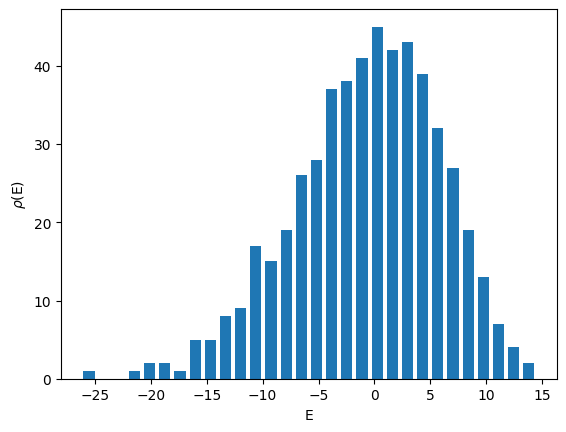

In [3]:
def Heisenberg_time(eig, bins = 30):
    vals, bins = np.histogram(eig, bins=bins)
    width = np.std(bins)/2
    eig2 = eig[(eig>-width) & (eig<width)]
    ra = np.diff(eig2)
    DeltaE = np.mean(ra)
    tH = 2*np.pi/DeltaE
    return tH

k = 1.5
N = 10
ising_params = {'N': N,
                    'hx': 1, 'hz': k,
                    'jx': 0, 'jy': 0, 'jz': 1}
H_all = h_ising_transverse(**ising_params, to_numpy=False)
Hp=to_even_subspace(H_all)
H=np.real(Hp.full())
eig,evec=linalg.eigh(H)

vals, bins = np.histogram(eig, bins=30)
plt.bar(bins[:-1],vals,width=1)
plt.xlabel('E')
plt.ylabel(r'$\rho$(E)')

tH = Heisenberg_time(eig)
print('Heisenberg time: ', tH)

In [8]:
tHs = []
for i in tqdm(range(5,11)):
    k = 1.5
    N = i
    ising_params = {'N': N,
                        'hx': 1, 'hz': k,
                        'jx': 0, 'jy': 0, 'jz': 1}
    H_all = h_ising_transverse(**ising_params, to_numpy=False)
    Hp=to_even_subspace(H_all)
    H=np.real(Hp.full())
    eig,evec=linalg.eigh(H)
    tH = Heisenberg_time(eig)
    tHs.append(tH)

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:02<00:00,  2.45it/s]


### Scrambling time

In the following cells we calculate the scrambling time, which is the time where the K-complexity reaches half a plateau. Then, we study the scaling of such time with the dimension of the Hilbert space (the number of spins). 

  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 8/8 [03:32<00:00, 26.56s/it]


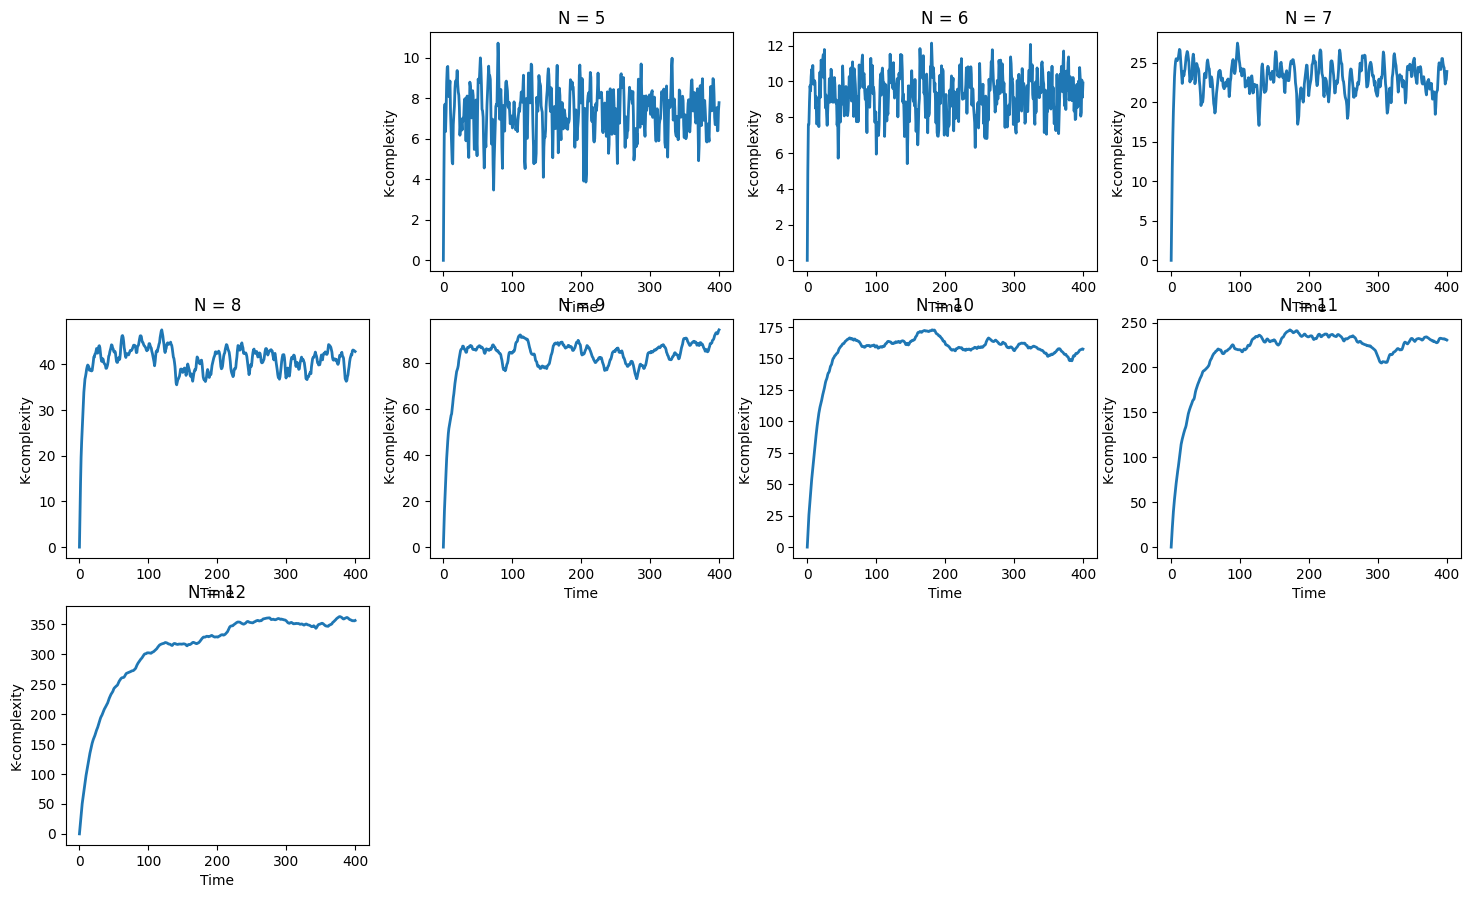

In [49]:
nk=10
k=np.array([1])#np.linspace(0.01,4,nk)
ts = [40.,50.,80., 100., 120., 150., 200., 200.]
j=0
xs,ys = [], []
for N in tqdm(range(5,13,1)):
    tmax = 400. # ts[j]
    j+=1
     # Initial state
    va = []
    vb = []
    mc = []
    cha = []

    # Initial state
    k0 =5
    ising_params = {'N': N,
                        'hx': 1, 'hz': k0,
                        'jx': 0, 'jy': 0, 'jz': 1}
    H_all = h_ising_transverse(**ising_params, to_numpy=False)
    Hp=to_even_subspace(H_all)
    H=np.real(Hp.full())
    eig,evec=linalg.eig(H)
    ff=evec[0]

    for i in range(len(k)):
        # Create Hamiltonian
        k0=k[i]
        ising_params = {'N': N,
                        'hx': 1, 'hz': k0,
                        'jx': 0, 'jy': 0, 'jz': 1}
        H_all = h_ising_transverse(**ising_params, to_numpy=False)
        Hp=to_even_subspace(H_all)
        H=np.real(Hp.full())
        # Calculate unitary wit qutip
        F = H
        
        # Calculate r
        ei=np.sort(np.real(linalg.eigvals(F)))
        cha.append(r_chaometer(ei,False))

        # Calculate Krilov basis           
        a,b,c=FO_state(F,ff)
        # Calculate Krilov compleity
        x,y=k_complexity(a,b, tmax, ntimes=500)
        mc.append(np.mean(np.real(y[-250:]))) # Mean complexity
        xs.append(x)
        ys.append(y)

        plt.figure(19,figsize=(18,18))
        plt.subplot(5, 4, N+1)
        plt.plot(x,np.real(y),linewidth=2,label=k0)
        plt.title('N = '+ str(N))
        plt.xlabel('Time')
        plt.ylabel('K-complexity')

        # Calculate variance b with respect to the mean
        x1=np.linspace(0.,len(b),len(b))
        df = pd.DataFrame({'B': b})
        yy=df.rolling(window=10).std()
        yycut=yy[10:]
        xxcut=x1[10:]
        vb.append(yycut.mean().iloc[0]) # Variance b
        
        # Calculate variance a with respect to the mean
        x1=np.linspace(0.,len(a),len(a))
        df = pd.DataFrame({'A': np.real(a)})
        yy=df.rolling(window=10).std()
        yycut=yy[10:]
        xxcut=x1[10:]
        va.append(yycut.mean().iloc[0]) # Variance a
            
variance_a = np.array(va)
variance_b = np.array(vb)
mean_comp = np.array(mc)
mean_chaos = np.array(cha)

In [13]:
Ns = range(5,13,1)
tScr = []
for i in tqdm(Ns):
    k = 1.5
    N = i
    tmax  = 400
    ising_params = {'N': N,
                    'hx': 1, 'hz': k,
                    'jx': 0, 'jy': 0, 'jz': 1}
    H_all = h_ising_transverse(**ising_params, to_numpy=False)
    Hp=to_even_subspace(H_all)
    F=np.real(Hp.full())
    eig,evec=linalg.eig(F)
    ff = evec[0]
    # Calculate Hamiltonian
    k = 1.5
    ising_params = {'N': N,
                        'hx': 1, 'hz': k,
                        'jx': 0, 'jy': 0, 'jz': 1}
    H_all = h_ising_transverse(**ising_params, to_numpy=False)
    Hp=to_even_subspace(H_all)
    F=np.real(Hp.full())
    # Calculate Krilov basis           
    a,b,c=FO_state(F,ff)
    # Calculate Krilov compleity
    x,y=k_complexity(a,b, tmax, ntimes=500)
    mean_comp = np.mean(y)
    idx = np.argmin(np.abs(y - mean_comp/2))
    tS = x[idx]
    if y[1]>mean_comp/2:
        tS = x[1]
    tScr.append(tS)
    


100%|██████████| 8/8 [03:36<00:00, 27.11s/it]


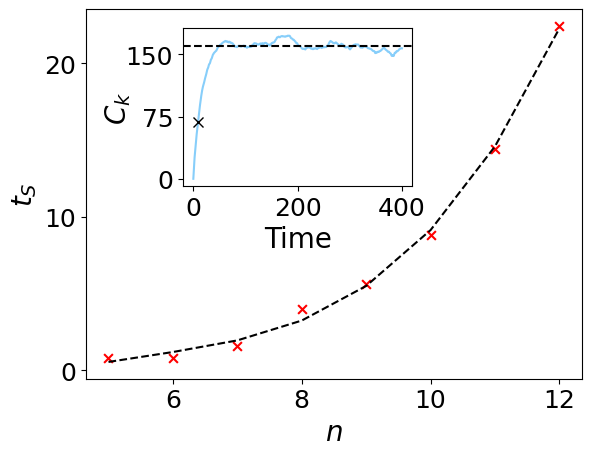

In [52]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
Ns = range(5,13,1)
plateau = [5, 12, 18, 30, 40, 70, 115, 150]
fig, ax = plt.subplots(1,1)
ax.scatter(Ns, tScr, marker ='x', s=40, color = 'red')
ax.set_xticks([6,8,10,12], ['6', '8', '10', '12'], fontsize=18)
ax.set_yticks([0,10,20], ['0', '10', '20'], fontsize=18)
z = np.polyfit(Ns, tScr, 3)
p = np.poly1d(z)
ax.plot(Ns, p(Ns), color='black', linestyle='dashed')
#ax.text(10.5,10, '$N^3$', fontsize=15)
ax.set_xlabel(r'$n$', fontsize=20)
ax.set_ylabel(r'$t_S$', fontsize=20)
axins = inset_axes(ax, width="45%", height="45%", loc=2, bbox_to_anchor = (170,60,510,350))
i=5
axins.plot(xs[i], ys[i], color = 'lightskyblue')
axins.set_xlabel('Time', fontsize=20)
axins.set_ylabel(r'$C_k$', fontsize=20, labelpad=-5)
axins.set_xticks([0, 200, 400], ['0', '200', '400'], fontsize=18)
axins.set_yticks([0,75, 150], ['0', '75', '150'], fontsize=18)
axins.axhline(y = np.mean(ys[i][-300:]), linewidth=1.5, linestyle='dashed', color='black')
pos = np.argmin(np.abs(xs[i] - tScr[i]))
axins.plot(tScr[i], ys[i][pos], marker ='x', markersize=7, color = 'black')

### Comparison Heisenberg and Scrambling time

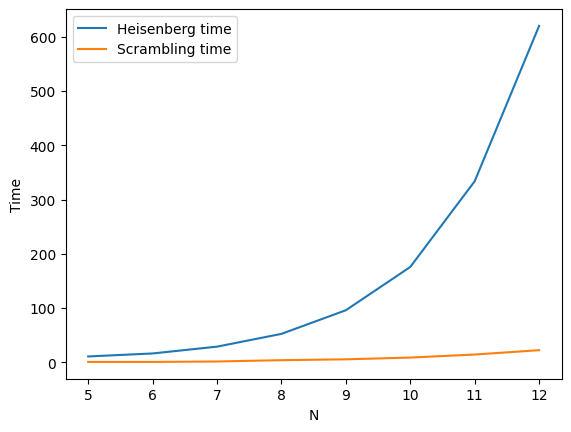

In [41]:
Ns = range(5,13)
plateau = [5, 12, 18, 30, 40, 70, 115, 150]
plt.plot(Ns, tHs, label='Heisenberg time')
plt.plot(Ns, tScr, label='Scrambling time')
plt.xlabel('N')
plt.ylabel('Time')
plt.legend()
plt.show()

## Calculate Krylov statistics for the Ising Hamiltonian

We make the calculations for the three different time scales

In [413]:
nk=50
tmax=500.
k=np.linspace(0.01,4,nk)
N = 10
num_initial_states = 1


# Initial state
k0 =5
ising_params = {'N': N,
                    'hx': 1, 'hz': k0,
                    'jx': 0, 'jy': 0, 'jz': 1}
H_all = h_ising_transverse(**ising_params, to_numpy=False)
Hp=to_even_subspace(H_all)
H=np.real(Hp.full())
eig,evec=linalg.eig(H)

# Lists with results
variance_a= []
variance_b = []
mean_comp = []
mean_chaos = []
tHs = []

for j in range(num_initial_states):
    ff=evec[j] # Initial state
    va = []
    vb = []
    mc = []
    cha = []

    for i in tqdm(range(len(k))):
        # Create Hamiltonian
        k0=k[i]
        ising_params = {'N': N,
                        'hx': 1, 'hz': k0,
                        'jx': 0, 'jy': 0, 'jz': 1}
        H_all = h_ising_transverse(**ising_params, to_numpy=False)
        Hp=to_even_subspace(H_all)
        H=np.real(Hp.full())
        # Calculate relevant times
        eig,_=linalg.eigh(H)
        tH = Heisenberg_time(eig)
        tHs.append(tH)
        tE = tScr[5]
        ts = tE/2
        ts2 = tE/5
        ts3 = tE/10
        ts4 = tE/25
        ts5 = tE/50
        times = [tH, tE, ts, ts2, ts3, ts4, ts5, None]
        # Define lists to store statistics
        varia_a=[]
        varia_b=[]
        mea_comp=[]
        chaos = []

        for t in times:
            if t is None:
                F = H
            else:
                # Calculate unitary wit qutip
                H2 = 1j*t*Hp
                U = H2.expm()
                U = U.full()
                F = np.real(-1j/t*linalg.logm(U)) 
            
            # Calculate r
            ei=np.sort(np.real(linalg.eigvals(F)))
            chaos.append(r_chaometer(ei,False))

            # Calculate Krilov basis           
            a,b,c=FO_state(F,ff)
            # Calculate Krilov compleity
            x,y=k_complexity(a,b, tmax, ntimes=500)
            mea_comp.append(np.mean(np.real(y[-250:]))) # Mean complexity

            # Calculate variance b with respect to the mean
            x1=np.linspace(0.,len(b),len(b))
            df = pd.DataFrame({'B': b})
            yy=df.rolling(window=10).std()
            yycut=yy[10:]
            xxcut=x1[10:]
            varia_b.append(yycut.mean().iloc[0]) # Variance b
            
            # Calculate variance a with respect to the mean
            x1=np.linspace(0.,len(a),len(a))
            df = pd.DataFrame({'A': np.real(a)})
            yy=df.rolling(window=10).std()
            yycut=yy[10:]
            xxcut=x1[10:]
            varia_a.append(yycut.mean().iloc[0]) # Variance a
            
        va.append(varia_a)
        vb.append(varia_b)
        mc.append(mea_comp)
        cha.append(chaos)

    variance_a.append(va)
    variance_b.append(vb)
    mean_comp.append(mc)
    mean_chaos.append(cha)

variance_a = np.array(variance_a)
variance_b = np.array(variance_b)
mean_comp = np.array(mean_comp)
mean_chaos = np.array(mean_chaos)
tHs = np.array(tHs)

100%|██████████| 50/50 [07:20<00:00,  8.82s/it]


In [419]:
with open('results/Ising_mean_comp_10_3.npy', 'wb') as f:
    np.save(f, mean_comp)

with open('results/Ising_var_a_10_3.npy', 'wb') as f:
    np.save(f, variance_a)

with open('results/Ising_var_b_10_3.npy', 'wb') as f:
    np.save(f, variance_b)

with open('results/Ising_mean_chaos_10_3.npy', 'wb') as f:
    np.save(f, mean_chaos)


## Load all results

In [4]:
with open('results/Ising_mean_comp_10_3.npy', 'rb') as f:
    mean_comp = np.load(f)

with open('results/Ising_var_a_10_3.npy', 'rb') as f:
    variance_a = np.load(f)

with open('results/Ising_var_b_10_3.npy', 'rb') as f:
    variance_b = np.load(f)

with open('results/Ising_mean_chaos_10_3.npy', 'rb') as f:
    mean_chaos = np.load(f)
nk=50
k=np.linspace(0.01,4,nk)
N = 10

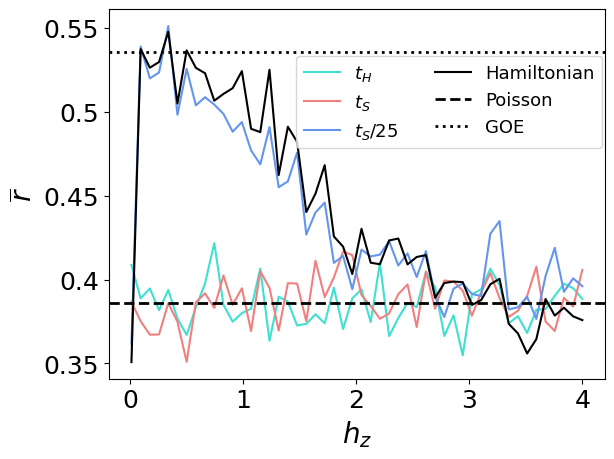

In [6]:
plt.plot(k, np.mean(mean_chaos[:,:,0], axis=0), color='turquoise', label=r'$t_H$')
plt.plot(k, np.mean(mean_chaos[:,:,1], axis=0), color='lightcoral', label=r'$t_S$')
plt.plot(k, np.mean(mean_chaos[:,:,8], axis=0), color='cornflowerblue', label=r'$t_S/25$')
plt.plot(k, np.mean(mean_chaos[:,:,7], axis=0), color='black', label='Hamiltonian')
plt.axhline(y=0.38629, linestyle='dashed', linewidth=2,  color='black', label='Poisson')
plt.axhline(y=0.53590, linestyle='dotted', linewidth=2, color='black', label='GOE')
plt.xlabel(r'$h_z$', fontsize=20)
plt.ylabel(r'$\overline{r}$', fontsize=20)
plt.xticks([0,1,2,3,4], [0,1,2,3,4], fontsize=18)
plt.yticks([0.35,0.4,0.45, 0.5, 0.55], [0.35,0.4,0.45, 0.5, 0.55], fontsize=18)
plt.legend(bbox_to_anchor=(0.36, 0.6), fontsize=13, ncols=2)

Text(-0.15, 165, '(b)')

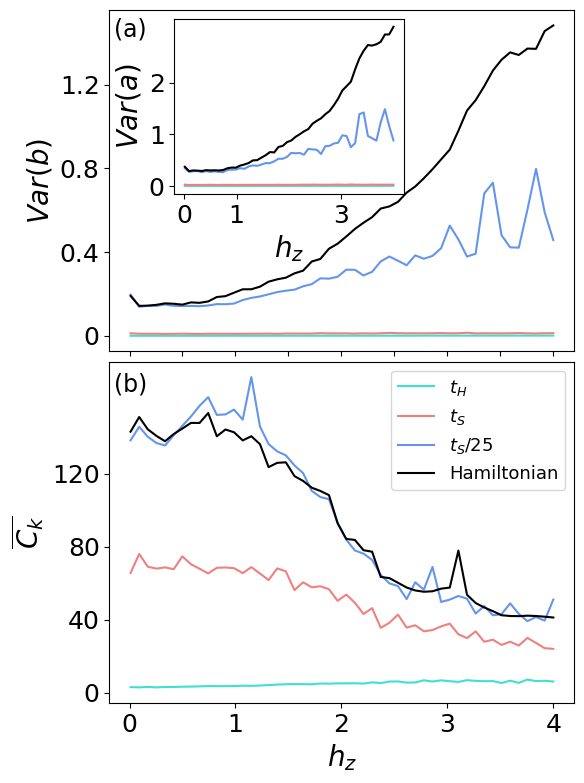

In [7]:
fig, (ax1, ax3)= plt.subplots(2,1, figsize=(6,9))
plt.subplots_adjust(hspace=0.03)

ax1.plot(k, np.mean(variance_b[:,:,0], axis=0), color='turquoise',label='Heisenberg time')
ax1.plot(k, np.mean(variance_b[:,:,1], axis=0), color='lightcoral',label='Scrambling time')
ax1.plot(k, np.mean(variance_b[:,:,8], axis=0), color='cornflowerblue',label='tScr/25')
ax1.plot(k, np.mean(variance_b[:,:,7], axis=0), color='black', label='True (Hamiltonian)')
ax1.tick_params(labelbottom=False)    
ax1.set_yticks([0,0.4,0.8,1.2], [0,0.4,0.8,1.2], fontsize=18)
ax1.set_ylabel(r'$Var(b)$', fontsize=20)

ax2 = inset_axes(ax1, width="45%", height="50%",loc=2, bbox_to_anchor = (133,440,510,350))
ax2.plot(k, np.mean(variance_a[:,:,0], axis=0), color='turquoise')
ax2.plot(k, np.mean(variance_a[:,:,1], axis=0), color='lightcoral')
ax2.plot(k, np.mean(variance_a[:,:,8], axis=0), color='cornflowerblue')
ax2.plot(k, np.mean(variance_a[:,:,7], axis=0), color='black')
ax2.set_yticks([0,1,2], [0,1,2], fontsize=18)
ax2.set_ylabel(r'$Var(a)$', fontsize=20)
ax2.set_xticks([ 0,1,3], [0,1,3 ], fontsize=18)
ax2.set_xlabel(r'$h_z$', fontsize=20)

ax3.plot(k, np.mean(mean_comp[:,:,0], axis=0), color='turquoise',label=r'$t_H$')
ax3.plot(k, np.mean(mean_comp[:,:,1], axis=0), color='lightcoral',label=r'$t_S$')
ax3.plot(k, np.mean(mean_comp[:,:,8], axis=0), color='cornflowerblue',label=r'$t_S/25$')
ax3.plot(k, np.mean(mean_comp[:,:,7], axis=0), color='black', label='Hamiltonian')

ax3.set_xticks([0,1,2,3,4], [0,1,2,3,4], fontsize=18)
ax3.set_yticks([0,40,80,120], [0,40,80,120], fontsize=18)
ax3.set_xlabel(r'$h_z$', fontsize=20)
ax3.set_ylabel(r'$\overline{C_k}$', fontsize=20)
ax3.legend(fontsize=13)

ax1.text(-0.15,1.43, '(a)', fontsize=17)
ax3.text(-0.15, 165, '(b)', fontsize=17)

## Krylov approach with reduced Lanczos coefficients
In this section, we study the performance of the Krylov approach when considering only a simplified subset of coefficients from the complete Lanczos sequence. Rather than calculating the Krylov complexity and statistics using all coefficients $a$ and $b$, we perform the calculations here using only a fraction of these coefficients while disregarding the tail end of the sequence.

In [ ]:
nk=50
tmax=500.
k=np.linspace(0.01,4,nk)
N = 10
num_initial_states = 1


# Initial state
k0 =5
ising_params = {'N': N,
                    'hx': 1, 'hz': k0,
                    'jx': 0, 'jy': 0, 'jz': 1}
H_all = h_ising_transverse(**ising_params, to_numpy=False)
Hp=to_even_subspace(H_all)
H=np.real(Hp.full())
eig,evec=linalg.eig(H)

# Lists with results
variance_a= []
variance_b = []
mean_comp = []
mean_chaos = []
size_k = [1, 1/2, 1/4, 1/8, 1/16]

for j in range(num_initial_states):
    ff=evec[j] # Initial state
    va = []
    vb = []
    mc = []
    cha = []

    for i in tqdm(range(len(k))):
        # Create Hamiltonian
        k0=k[i]
        ising_params = {'N': N,
                        'hx': 1, 'hz': k0,
                        'jx': 0, 'jy': 0, 'jz': 1}
        H_all = h_ising_transverse(**ising_params, to_numpy=False)
        Hp=to_even_subspace(H_all)
        H=np.real(Hp.full())

        # Define lists to store statistics
        varia_a=[]
        varia_b=[]
        mea_comp=[]
        chaos = []

        for coef in size_k:
            F = H            
            # Calculate r
            ei=np.sort(np.real(linalg.eigvals(F)))
            chaos.append(r_chaometer(ei,False))

            # Calculate Krilov basis           
            a,b,c=FO_state(F,ff)
            a = a[:int(len(a)*coef)]
            b = b[:int(len(b)*coef)]
            # Calculate Krilov compleity
            x,y=k_complexity(a,b, tmax, ntimes=500)
            mea_comp.append(np.mean(np.real(y[-250:]))) # Mean complexity

            # Calculate variance b with respect to the mean
            x1=np.linspace(0.,len(b),len(b))
            df = pd.DataFrame({'B': b})
            yy=df.rolling(window=10).std()
            yycut=yy[10:]
            xxcut=x1[10:]
            varia_b.append(yycut.mean().iloc[0]) # Variance b
            
            # Calculate variance a with respect to the mean
            x1=np.linspace(0.,len(a),len(a))
            df = pd.DataFrame({'A': np.real(a)})
            yy=df.rolling(window=10).std()
            yycut=yy[10:]
            xxcut=x1[10:]
            varia_a.append(yycut.mean().iloc[0]) # Variance a
            
        va.append(varia_a)
        vb.append(varia_b)
        mc.append(mea_comp)
        cha.append(chaos)

    variance_a.append(va)
    variance_b.append(vb)
    mean_comp.append(mc)
    mean_chaos.append(cha)

variance_a = np.array(variance_a)
variance_b = np.array(variance_b)
mean_comp = np.array(mean_comp)
mean_chaos = np.array(mean_chaos)

In [12]:
with open('results/Ising_mean_comp_400_short_coefs.npy', 'wb') as f:
    np.save(f, mean_comp)

with open('results/Ising_var_a_400_short_coefs.npy', 'wb') as f:
    np.save(f, variance_a)

with open('results/Ising_var_b_400_short_coefs.npy', 'wb') as f:
    np.save(f, variance_b)

with open('results/Ising_mean_chaos_400_short_coefs.npy', 'wb') as f:
    np.save(f, mean_chaos)


## Load all results

In [8]:
with open('results/Ising_mean_comp_400_short_coefs.npy', 'rb') as f:
    mean_comp = np.load(f)

with open('results/Ising_var_a_400_short_coefs.npy', 'rb') as f:
    variance_a = np.load(f)

with open('results/Ising_var_b_400_short_coefs.npy', 'rb') as f:
    variance_b = np.load(f)

with open('results/Ising_mean_chaos_400_short_coefs.npy', 'rb') as f:
    mean_chaos = np.load(f)
nk=50
tmax=500.
k=np.linspace(0.01,4,nk)

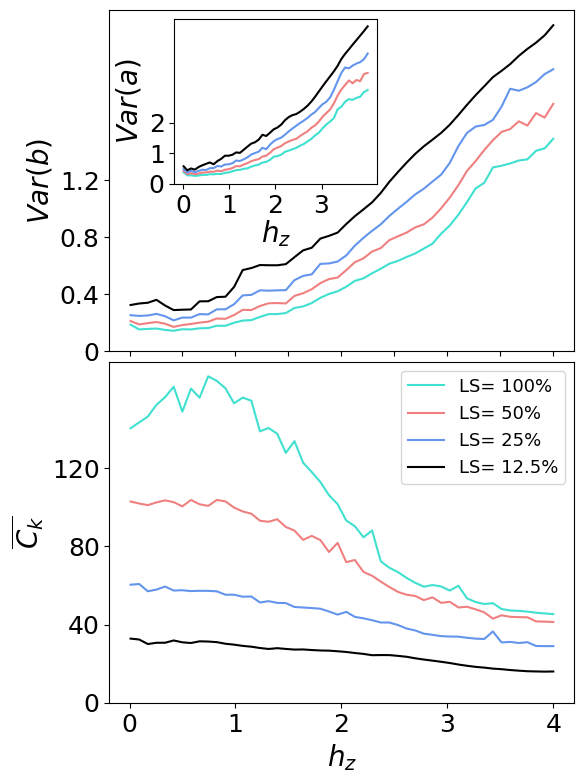

In [9]:
fig, (ax1, ax3)= plt.subplots(2,1, figsize=(6,9))
plt.subplots_adjust(hspace=0.03)

ax1.plot(k, np.mean(variance_b[:,:,0], axis=0), color='turquoise',label='Heisenberg time')
ax1.plot(k, np.mean(variance_b[:,:,1], axis=0), color='lightcoral',label='Scrambling time')
ax1.plot(k, np.mean(variance_b[:,:,2], axis=0), color='cornflowerblue',label='tScr/25')
ax1.plot(k, np.mean(variance_b[:,:,3], axis=0), color='black', label='True (Hamiltonian)')
ax1.tick_params(labelbottom=False)    
ax1.set_yticks([0,0.4,0.8,1.2], [0,0.4,0.8,1.2], fontsize=18)
ax1.set_ylabel(r'$Var(b)$', fontsize=20)

ax2 = inset_axes(ax1, width="45%", height="50%",loc=2, bbox_to_anchor = (133,460,450,330))
ax2.plot(k, np.mean(variance_a[:,:,0], axis=0), color='turquoise')
ax2.plot(k, np.mean(variance_a[:,:,1], axis=0), color='lightcoral')
ax2.plot(k, np.mean(variance_a[:,:,2], axis=0), color='cornflowerblue')
ax2.plot(k, np.mean(variance_a[:,:,3], axis=0), color='black')
ax2.set_yticks([0,1,2], [0,1,2], fontsize=18)
ax2.set_ylabel(r'$Var(a)$', fontsize=20)
ax2.set_xticks([ 0,1,2,3], [0,1,2,3 ], fontsize=18)
ax2.set_xlabel(r'$h_z$', fontsize=20, labelpad=0.1)

ax3.plot(k, np.mean(mean_comp[:,:,0], axis=0), color='turquoise',label=r'LS= 100%')
ax3.plot(k, np.mean(mean_comp[:,:,1], axis=0), color='lightcoral',label=r'LS= 50%')
ax3.plot(k, np.mean(mean_comp[:,:,2], axis=0), color='cornflowerblue',label=r'LS= 25%')
ax3.plot(k, np.mean(mean_comp[:,:,3], axis=0), color='black',label=r'LS= 12.5%')
ax3.set_xticks([0,1,2,3,4], [0,1,2,3,4], fontsize=18)
ax3.set_yticks([0,40,80,120], [0,40,80,120], fontsize=18)
ax3.set_xlabel(r'$h_z$', fontsize=20)
ax3.set_ylabel(r'$\overline{C_k}$', fontsize=20)
ax3.legend(fontsize=13)